In [1]:
import pandas as pd
import geopandas as gp
import pylab as pl
import numpy as np
import os
import sys 
import datetime as dt
import shapely as shp
from fiona.crs import from_epsg
import seaborn as sns

% pylab inline

Populating the interactive namespace from numpy and matplotlib


# get loac data

In [2]:
loac = gp.GeoDataFrame.from_file('LOAC.shp')

# limit to westminster

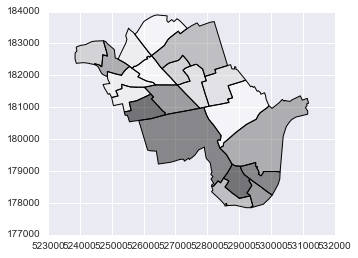

In [3]:
westminster_boundary = loac[loac.LAD11NM == 'Westminster']
westminster_boundary.dissolve('WD11NM_BF').plot()

# convert lat/long

In [4]:
westminster_boundary.crs = from_epsg(27700)
westminster_boundary = westminster_boundary.to_crs(epsg = 4326)

In [5]:
west_bound = westminster_boundary.dissolve('WD11NM_BF')

In [9]:
westminster_boundary.reset_index(inplace = True)

# get origin & destination data

In [29]:
from_station = pd.read_csv('ODS.csv')

# idenify lowest zone for those stations in 2 zones

In [35]:
from_station = from_station.loc[:, :'Zone']

In [36]:
from_station['first_zone'] = from_station['Zone'].apply(lambda x: int(x.split(',')[0]))

In [46]:
from_station.columns = ['FromID', 'From', 'ToID', 'To', 'Early', 'AM peak', 'Midday', 
                        'PM Peak', 'Evening', 'Late', 'Evening Late Total', 'Zone', 'first_zone']

In [47]:
from_station.head()

,FromID,From,ToID,To,Early,AM peak,Midday,PM Peak,Evening,Late,Evening Late Total,Zone,first_zone
0,669,Oxford Circus,741,Victoria,28,158,2139,2978,1596,649,2245,1,1
1,513,Bank / Monument,728,TottenhamCourtRoad,94,807,1220,792,1054,297,1351,1,1
2,625,King's Cross St. Pancras,741,Victoria,119,1965,1887,1251,1022,244,1266,1,1
3,574,Euston,741,Victoria,152,1359,1691,2157,956,286,1242,1,1
4,674,Piccadilly Circus,670,Paddington,0,36,495,872,623,458,1081,1,1


In [48]:
station_location = pd.read_csv('FromStationColapsed.csv.csv')

In [49]:
station_location['FROM STATION'].unique()

array(['ActonTown', 'Aldgate', 'AldgateEast', 'Alperton', 'Amersham',
       'Angel', 'Archway', 'ArnosGrove', 'Arsenal', 'BakerStreet',
       'Balham', 'Bank/Monument', 'Barbican', 'Barking', 'Barkingside',
       'BaronsCourt', 'Bayswater', 'Becontree', 'BelsizePark',
       'Bermondsey', 'BethnalGreen', 'Blackfriars', 'BlackhorseRoad',
       'BondStreet', 'Borough', 'BostonManor', 'BoundsGreen', 'BowRoad',
       'BrentCross', 'Brixton', 'Bromley-by-Bow', 'BuckhurstHill',
       'BurntOak', 'CaledonianRoad', 'CamdenTown', 'CanadaWater',
       'CanaryWharf', 'CanningTown', 'CannonStreet', 'CanonsPark',
       'ChalfontandLatimer', 'ChalkFarm', 'ChanceryLane', 'CharingCross',
       'Chesham', 'Chigwell', 'ChiswickPark', 'Chorleywood',
       'ClaphamCommon', 'ClaphamNorth', 'ClaphamSouth', 'Cockfosters',
       'Colindale', 'ColliersWood', 'CoventGarden', 'Croxley',
       'DagenhamEast', 'DagenhamHeathway', 'Debden', 'DollisHill',
       'EalingBroadway', 'EalingCommon', 'EarlsCo

In [52]:
from_station.From.unique()

array(['Oxford Circus', 'Bank / Monument', "King's Cross St. Pancras",
       'Euston', 'Piccadilly Circus', 'Embankment', 'Wembley Central',
       'Green Park', 'Leicester Square', 'Warren Street',
       'South Kensington', 'Farringdon', 'Tottenham Court Road',
       'Moorgate', 'Victoria', 'Whitechapel', 'Liverpool Street',
       'Sloane Square', 'Knightsbridge', 'Hammersmith (Dis)',
       'Euston Square', 'Highbury & Islington', 'Blackfriars', 'Brixton',
       'Charing Cross', 'Covent Garden', 'Marylebone', 'Paddington',
       'Hammersmith (H&C)', 'Westminster', 'Temple', 'Holborn',
       'Camden Town', 'Gloucester Road', 'Stratford', 'Canary Wharf',
       'North Greenwich', 'Mansion House', 'Goodge Street', "St. Paul's",
       'Tower Hill', 'High Street Kensington', 'Chalk Farm', 'Balham',
       'Harlesden', 'London Bridge', 'Old Street', 'Waterloo',
       "Earl's Court", 'Bayswater', 'Fulham Broadway', 'Barbican',
       'Bond Street', 'Queensway', 'Richmond', 'Turnpik

In [53]:
from_station.To = from_station.To.apply(lambda x: x.replace(' ', ''))
from_station.To = from_station.To.apply(lambda x: x.replace("'", ""))
from_station.From = from_station.From.apply(lambda x: x.replace(' ', ''))
from_station.From = from_station.From.apply(lambda x: x.replace("'", ""))

In [71]:
bad = []
for x in from_station.From.unique():
    if x in station_location['FROM STATION'].unique(): 
        pass
    else: 
        bad.append(x)

In [72]:
bad

['KingsCrossSt.Pancras',
 'Hammersmith(Dis)',
 'Highbury&Islington',
 'Hammersmith(H&C)',
 'Elephant&Castle',
 'Harrow&Wealdstone',
 'Totteridge&Whetstone',
 'Chalfont&Latimer']

In [74]:
bad = []
for x in station_location['FROM STATION'].unique():
    if x in from_station.From.unique(): 
        pass
    else: 
        bad.append(x)

In [75]:
bad

['ChalfontandLatimer',
 'ElephantandCastle',
 'Hammersmith(HandC)',
 'HarrowandWealdstone',
 'HighburyandIslington',
 'KingsCrossSt.',
 'TotteridgeandWhetstone',
 '(blank)',
 'Grand Total']

# Fix non corresponding names

In [76]:
station_location['FROM STATION'] = station_location['FROM STATION'].apply(lambda x: x.replace('and', '&'))
station_location['FROM STATION'] = station_location['FROM STATION'].apply(lambda x: x.replace('KingsCrossSt.', 'KingsCrossSt.Pancras')                 )

In [77]:
bad = []
for x in from_station.From.unique():
    if x in station_location['FROM STATION'].unique(): 
        pass
    else: 
        bad.append(x)

In [78]:
bad

['Hammersmith(Dis)', 'GreatPortlandStreet', 'HollandPark']

In [79]:
bad = []
for x in station_location['FROM STATION'].unique():
    if x in from_station.From.unique(): 
        pass
    else: 
        bad.append(x)
bad

['GreatPortl&Street', 'Holl&Park', '(blank)', 'Gr& Total']

In [80]:
station_location['FROM STATION'] = station_location['FROM STATION'].apply(lambda x: x.replace('GreatPortl&Street', 
                                                                                              'GreatPortlandStreet'))
station_location['FROM STATION'] = station_location['FROM STATION'].apply(lambda x: x.replace('Holl&Park', 
  'HollandPark'))

# Identify Stations in Westminster

In [87]:
station_location['geometry'] = station_location.apply(lambda row: shp.geometry.Point(row["FROM Longitude"], 
                                                                                        row["FROM Latitude"]), axis=1)
station_location = gp.GeoDataFrame(station_location)

In [88]:
in_westmin = [westminster_boundary.dissolve('LAD11CD').geometry[0].contains(station_location.geometry[x]) for x in station_location.index]

In [90]:
station_location['in_westmin'] = in_westmin

In [92]:
from_station = from_station.merge(station_location[['geometry', 'FROM STATION', 'in_westmin']], left_on = 'To', 
                                  right_on = 'FROM STATION', how = 'left')

In [93]:
from_station = from_station.merge(station_location[['geometry', 'FROM STATION']], left_on = 'From', 
                                  right_on = 'FROM STATION', how = 'left')

In [98]:
from_station.columns = ['FromID', 'From', 'ToID', 'To', 'Early', 'AM peak', 'Midday', 'PM Peak',
       'Evening', 'Late', 'Evening Late Total', 'Zone', 'first_zone',
       'geometry_to', 'to_station', 'in_westmin', 'geometry_from',
       'from_station']

In [99]:
from_station.head()

,FromID,From,ToID,To,Early,AM peak,Midday,PM Peak,Evening,Late,Evening Late Total,Zone,first_zone,geometry_to,to_station,in_westmin,geometry_from,from_station
0,669,OxfordCircus,741,Victoria,28,158,2139,2978,1596,649,2245,1,1,POINT (-0.143920706 51.49642395),Victoria,True,POINT (-0.140836171 51.5152234),OxfordCircus
1,513,Bank/Monument,728,TottenhamCourtRoad,94,807,1220,792,1054,297,1351,1,1,POINT (-0.131110439 51.51621087),TottenhamCourtRoad,True,POINT (-0.089000124 51.51334706),Bank/Monument
2,625,KingsCrossSt.Pancras,741,Victoria,119,1965,1887,1251,1022,244,1266,1,1,POINT (-0.143920706 51.49642395),Victoria,True,POINT (-0.122756421 51.53079819),KingsCrossSt.Pancras
3,574,Euston,741,Victoria,152,1359,1691,2157,956,286,1242,1,1,POINT (-0.143920706 51.49642395),Victoria,True,POINT (-0.133296472 51.52866433),Euston
4,674,PiccadillyCircus,670,Paddington,0,36,495,872,623,458,1081,1,1,POINT (-0.175736752 51.51539379),Paddington,True,POINT (-0.133711597 51.50969675),PiccadillyCircus


In [103]:
to_westmin = from_station[from_station.in_westmin == True]

In [104]:
agg_westmin = to_westmin.groupby(['From', 'To']).agg({'Evening Late Total': 'sum'}).unstack()

In [106]:
agg_westmin.fillna(0, inplace = True)

In [107]:
agg_westmin.columns = agg_westmin.columns.droplevel(0)

In [158]:
agg_westmin_geom = agg_westmin.merge(station_location[['geometry', 'FROM STATION', 'FROM Zone']], how = 'left',
                 left_index = True, right_on = 'FROM STATION')

In [159]:
agg_westmin_geom['zone'] = agg_westmin_geom['FROM Zone'].apply(lambda x: str(x)[0])

In [177]:
agg_westmin_geom.to_csv('agg_westmin_all.csv', encoding = 'UTF-8')

In [178]:
agg_westmin_geom = pd.read_csv('agg_westmin_all.csv')

In [179]:
agg_westmin_geom = gp.GeoDataFrame(agg_westmin_geom)